# Tomography Debugger
State tomography involves measuring a quantum state repeatedly in the bases given by `itertools.product(['X', 'Y', 'Z], repeat=n_qubits)`. From these measurements, we can reconstruct a density matrix $\rho$ using a varaiety of methods described in forest.benchmarking.tomography under the heading "state tomography". This is all done automaticly in using the forest.benchmarking.tomography.tomographize function allowing it to be use effectivly as a quantum debugger.

In [1]:
import numpy as np
import time

from pyquil import Program, get_qc
from pyquil.gates import *
from forest.benchmarking.tomography import tomographize

## Construct a state with a `Program`
We'll construct a two-qubit graph state by Hadamarding all qubits and then applying a controlled-Z operation across edges of our graph. In the two-qubit case, there's only one edge. 

In [2]:
qubits = [0, 1]

program = Program()
for qubit in qubits:
    program += H(qubit)
program += CZ(qubits[0], qubits[1])
program += RY(-np.pi/2, qubits[0])
program += X(qubits[1])
program += CNOT(qubits[1], qubits[0])

print(program)

H 0
H 1
CZ 0 1
RY(-pi/2) 0
X 1
CNOT 1 0



## Run the tomography debugger and print output

In [3]:
qc = get_qc('%dq-qvm' % len(qubits))


start_linear = time.time()
m = 10
rho_linear = tomographize(qc, program, qubits, pauli_num=10, t_type="linear_inv")
end_linear = time.time() - start_linear

print("Linear tomography took %gs" % end_linear)
print("Recovered density matrix:\n")
print(rho_linear)

start_compressed = time.time()
rho_compressed = tomographize(qc, program, qubits, pauli_num=10, t_type="compressed_sensing")
end_compressed = time.time() - start_compressed
print("Compressed tomography took %gs" % end_compressed)
print("Recovered density matrix:\n")
print(rho_compressed)

start_lasso = time.time()
rho_lasso = tomographize(qc, program, qubits, pauli_num=10, t_type="lasso")
end_lasso = time.time() - start_lasso
print("Compressed tomography took %gs" % end_lasso)
print("Recovered density matrix:\n")
print(rho_lasso)

Linear tomography took 0.460453s
Recovered density matrix:

[[ 3.50000000e-03-1.36512468e-18j  2.93058701e-19+1.50000000e-03j
   4.50000000e-03-3.50000000e-03j  5.50000000e-03-5.00000000e-04j]
 [-2.74342100e-17-1.50000000e-03j -3.50000000e-03+2.14325778e-18j
  -1.45000000e-02+5.00000000e-04j  4.50000000e-03+1.55000000e-02j]
 [ 4.50000000e-03+3.50000000e-03j -1.45000000e-02-5.00000000e-04j
   4.96500000e-01+1.13981602e-18j  6.83320553e-19-5.00000000e-04j]
 [ 5.50000000e-03+5.00000000e-04j  4.50000000e-03-1.55000000e-02j
  -6.83320553e-19+5.00000000e-04j  5.03500000e-01+5.30658834e-19j]]
Compressed tomography took 0.499431s
Recovered density matrix:

[[-2.53127791e-08-3.50638546e-17j -8.70056892e-03-1.64999653e-02j
   1.21925031e-08-4.21747408e-04j  8.39998555e-03+2.40000386e-02j]
 [-8.70056892e-03+1.64999653e-02j  4.71000042e-01+6.24351317e-18j
   1.10522052e-02+2.00001772e-03j -5.00000056e-01-1.94216460e-02j]
 [ 1.21917260e-08+4.21747408e-04j  1.10522052e-02-2.00001772e-03j
   3.825064

## Compare results to true output obtained using wavefunction simulator

In [4]:
from pyquil.api import WavefunctionSimulator
wf_sim = WavefunctionSimulator()
wf = wf_sim.wavefunction(program)
psi = wf.amplitudes

rho_true = np.outer(psi, psi.T.conj())
print(np.around(rho_true, decimals=3))

[[ 0. +0.j -0. -0.j  0. +0.j  0. +0.j]
 [-0. +0.j  0.5+0.j -0. +0.j -0.5+0.j]
 [ 0. +0.j -0. -0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.5-0.j  0. +0.j  0.5+0.j]]


## Visualize using Hinton plots

In [5]:
from matplotlib import pyplot as plt
from forest.benchmarking.plotting import hinton
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
hinton(rho_true, ax=ax1)
hinton(rho_linear, ax=ax2)
hinton(rho_compressed, ax=ax3)
ax1.set_title('Analytical Linear')
ax2.set_title('Estimated Linear')
ax3.set_title('Estimated Compressed')
fig.tight_layout()

## Calculate matrix norm between true and estimated rho

In [6]:
print("Linear norm:")
print(np.linalg.norm(rho_linear - rho_true))
print("Compressed norm:")
print(np.linalg.norm(rho_compressed - rho_true))
print("Lasso norm:")
print(np.linalg.norm(rho_lasso - rho_true))

Linear norm:
1.0050482575478652
Compressed norm:
0.07078083250036442
Lasso norm:
0.9749834380713842


## Plot graph of results for various measurement values

Analyzing performance of linear vs. compressed on program:
H 0
H 1
CZ 0 1
RY(-pi/2) 0
X 1
CNOT 1 0

Running iteration 1/16
Running iteration 2/16
Running iteration 3/16
Running iteration 4/16
Running iteration 5/16
Running iteration 6/16
Running iteration 7/16
Running iteration 8/16
Running iteration 9/16
Running iteration 10/16
Running iteration 11/16
Running iteration 12/16
Running iteration 13/16
Running iteration 14/16
Running iteration 15/16


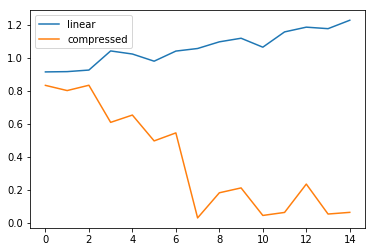

In [7]:
import matplotlib.pyplot as plt

max_pauli_num = 4 ** len(qubits)
num_trials = 5

linear_norms = []
compressed_norms = []

print("Analyzing performance of linear vs. compressed on program:")
print(program)

for i in range(1, max_pauli_num):
    print("Running iteration %d/%d" % (i, max_pauli_num))
    linear_norm_mean = 0.0
    compressed_norm_mean = 0.0
    for j in range(num_trials):
        rho_linear = tomographize(qc, program, qubits, pauli_num=i, t_type="linear_inv")
        rho_compressed = tomographize(qc, program, qubits, pauli_num=i, t_type="compressed_sensing")
        linear_norm_mean += np.linalg.norm(rho_linear - rho_true)
        compressed_norm_mean += np.linalg.norm(rho_compressed - rho_true)
    
    linear_norm_mean /= num_trials
    compressed_norm_mean /= num_trials
    
    linear_norms.append(linear_norm_mean)
    compressed_norms.append(compressed_norm_mean)

plt.plot(linear_norms, label='linear')
plt.plot(compressed_norms, label='compressed')
plt.legend()
plt.show()